# Benchmark Analysis

In [1]:
import sys
!{sys.executable} -m pip install -r requirements.txt

You should consider upgrading via the '/Users/diego/Documents/Studium/4_Semester/Masterarbeit/master_benchmarks/analysis/venv/bin/python -m pip install --upgrade pip' command.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from pathlib import Path
from typing import List

% matplotlib inline

In [3]:
root_dir = '/Users/diego/Desktop/BENCHMARK_COLLECTED_NEBULAH_B1-B4_1'

## Utils 

In [4]:
def get_path(*entries):
    return os.path.join(*entries)


In [5]:
def ensure_file_existence(output_filename):
    """
    Checks wheterh the path to the file exists. If not it creates the folder structure and the final file.
    :param output_filename: path to the file
    :return:
    """

    # creates dirs etc if they do not exists
    output_path = Path(output_filename)
    if not os.path.exists(output_path.parent):
        os.makedirs(output_path.parent)
    output_path.touch(exist_ok=True)  # will create file, if it exists will do nothing

In [6]:
def extraction_pandas_frame_algo(path):
    df = pd.read_csv(path)

    # dropping columns we do not care about
    df = df.drop(['iterations', 'bytes_per_second', 'items_per_second', 'label', 'error_occurred', 'error_message'],
                 axis=1)

    # adding the problem size as column
    df = df[df['name'].str.endswith(('mean', 'median', 'stddev'))]
    df['n'] = df.apply(lambda x: x[0][x[0].find('/') + 1:x[0].rfind('_')], axis=1)

    df = df.reset_index(drop=True)

    # convert to format 
    # name	real_time	cpu_time	time_unit	n	median	stddev	Compiler
    results_gcc = df.groupby('n').apply(lambda sf: pd.Series(sf.iloc[0])).reset_index(drop=True)
    results_gcc.n = results_gcc.n.astype(int)
    results_gcc = results_gcc.sort_values(['n'], ascending=True).reset_index(drop=True)

    results_gcc['C'] = np.arange(len(results_gcc))

    results_gcc['median_id'] = results_gcc['C'] * 3 + 1
    results_gcc['median'] = results_gcc['median_id'].apply(lambda x: df.iloc[x]['real_time'])

    results_gcc['stddev_id'] = results_gcc['C'] * 3 + 2
    results_gcc['stddev'] = results_gcc['stddev_id'].apply(lambda x: df.iloc[x]['real_time'])

    results_gcc = results_gcc.drop(['C', 'median_id', 'stddev_id'], axis=1)
    results_gcc['Compiler'] = 'TODO'
    results_gcc['name'] = results_gcc.apply(lambda x: x[0].replace(str(x['n']), "").replace('/_mean', ''), axis=1)

    return results_gcc


## Cleaning input files
The benchmark csv's are not parseable csv's because they have a header that is not valid csv. We first need to strip this away.

In [7]:
def clean_file_content(input_filename, output_filename):
    with open(input_filename, 'r+') as fr:
        lines = fr.readlines()

    with open(output_filename, 'w+') as fw:
        reached = False

        for line in lines:
            if line.startswith('name,iterations,real_time'):
                reached = True

            if reached:
                fw.write(line)


def clean_all_files(target_dir, target_prefix="cleaned"):
    for dirpath, dirnames, filenames in os.walk(target_dir):
        if not dirnames:
            print(dirpath, "has ", len(filenames), "files")
            final_files = [(os.path.join(dirpath, x), os.path.join(dirpath, target_prefix, x)) for x in filenames]

            for input_filename, output_filename in final_files:
                ensure_file_existence(output_filename)
                clean_file_content(input_filename, output_filename)
    print("Done!")


In [8]:
clean_all_files("/Users/diego/Desktop/BENCHMARK_COLLECTED_NEBULAH_B1-B4_1")
# in this case the location of the cleaned files will be /[DEFAULT|NUMACTL]/cleaned

/Users/diego/Desktop/BENCHMARK_COLLECTED_NEBULAH_B1-B4_1/NVHPC_Multicore/DEFAULT/cleaned/cleaned/cleaned/cleaned/cleaned/cleaned/cleaned/cleaned/cleaned has  65 files
/Users/diego/Desktop/BENCHMARK_COLLECTED_NEBULAH_B1-B4_1/GCC_TBB/DEFAULT/cleaned/cleaned/cleaned/cleaned/cleaned/cleaned/cleaned/cleaned/cleaned has  66 files
Done!


# Nebulah all Core
```
Linux nebulah 4.19.0-18-amd64 #1 SMP Debian 4.19.208-1 (2021-09-29) x86_64 GNU/Linux
```

```
Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
Address sizes:       43 bits physical, 48 bits virtual
CPU(s):              16
On-line CPU(s) list: 0-15
Thread(s) per core:  1
Core(s) per socket:  16
Socket(s):           1
NUMA node(s):        4
Vendor ID:           AuthenticAMD
CPU family:          23
Model:               1
Model name:          AMD EPYC 7351P 16-Core Processor
Stepping:            2
CPU MHz:             1197.568
CPU max MHz:         2400.0000
CPU min MHz:         1200.0000
BogoMIPS:            4790.88
Virtualization:      AMD-V
L1d cache:           32K
L1i cache:           64K
L2 cache:            512K
L3 cache:            8192K
NUMA node0 CPU(s):   0,4,8,12
NUMA node1 CPU(s):   1,5,9,13
NUMA node2 CPU(s):   2,6,10,14
NUMA node3 CPU(s):   3,7,11,15
```

## B1_1 GCC Seq, Par, Par_unseq

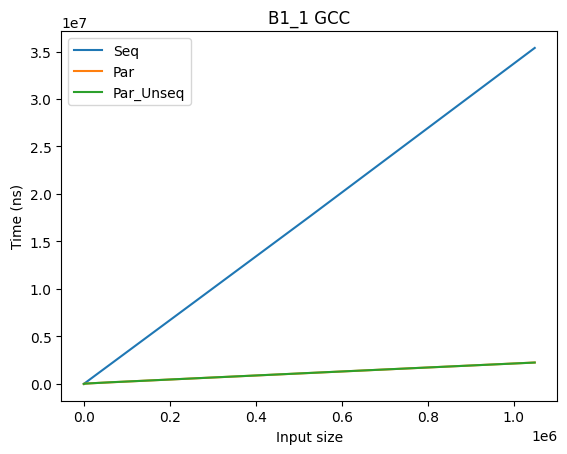

In [9]:
fig, ax = plt.subplots()

b1_1_gcc_seq = extraction_pandas_frame_algo(root_dir + '/GCC_TBB/DEFAULT/cleaned/b1_1_for_each_linear_seq_Default.csv')
b1_1_gcc_seq.plot(x='n', y='real_time', ax=ax, label='Seq')

b1_1_gcc_par = extraction_pandas_frame_algo(root_dir + '/GCC_TBB/DEFAULT/cleaned/b1_1_for_each_linear_par_Default.csv')
b1_1_gcc_par.plot(x='n', y='real_time', ax=ax, label='Par')

b1_1_gcc_par_unseq = extraction_pandas_frame_algo(
    root_dir + '/GCC_TBB/DEFAULT/cleaned/b1_1_for_each_linear_par_unseq_Default.csv')
b1_1_gcc_par_unseq.plot(x='n', y='real_time', ax=ax, label='Par_Unseq')

plt.ylabel('Time (ns)')
plt.xlabel('Input size')

ax.title.set_text("B1_1 GCC")

plt.show()

## B1_1 GCC - Speedup (16) 
https://www.dcc.fc.up.pt/~ricroc/aulas/1516/cp/apontamentos/slides_metrics.pdf

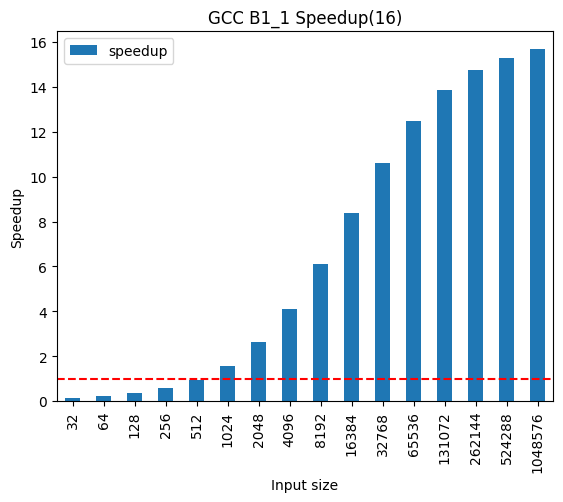

In [10]:
fig, ax = plt.subplots()

b1_1_gcc_seq = extraction_pandas_frame_algo(root_dir + '/GCC_TBB/DEFAULT/cleaned/b1_1_for_each_linear_seq_Default.csv')

b1_1_gcc_par = extraction_pandas_frame_algo(root_dir + '/GCC_TBB/DEFAULT/cleaned/b1_1_for_each_linear_par_Default.csv')

b1_1_gcc_speed_up_16 = pd.concat(
    [b1_1_gcc_seq['real_time'], b1_1_gcc_par['real_time'], b1_1_gcc_seq['n'], b1_1_gcc_par['n']], axis=1,
    keys=['seq_real_time', 'par_real_time', 'seq_n', 'par_n'])
b1_1_gcc_speed_up_16['speedup'] = b1_1_gcc_speed_up_16['seq_real_time'] / b1_1_gcc_speed_up_16['par_real_time']

b1_1_gcc_speed_up_16.plot(kind='bar', x='seq_n', y='speedup', ax=ax)

# adding horizontal line where there is speedup
ax.axhline(y=1, color='r', linestyle='--')

plt.ylabel('Speedup')
plt.xlabel('Input size')

plt.title('GCC B1_1 Speedup(16)')

plt.show()


## B1_1 GCC - Efficiency (16) 
https://www.dcc.fc.up.pt/~ricroc/aulas/1516/cp/apontamentos/slides_metrics.pdf

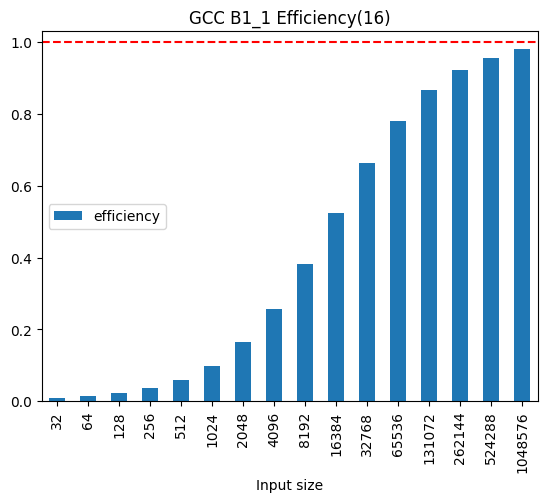

In [11]:
fig, ax = plt.subplots()

b1_1_gcc_efficiency_16 = b1_1_gcc_speed_up_16.copy()
b1_1_gcc_efficiency_16['p'] = 16
b1_1_gcc_efficiency_16['efficiency'] = b1_1_gcc_efficiency_16['speedup'] / b1_1_gcc_efficiency_16['p']

b1_1_gcc_efficiency_16.plot(kind='bar', x='seq_n', y='efficiency', ax=ax)

# adding horizontal line where there is optimal efficiency
ax.axhline(y=1, color='r', linestyle='--')

plt.xlabel('Input size')

plt.title('GCC B1_1 Efficiency(16)')

plt.show()

## B1_1 NVC (MC) Seq, Par, Par_unseq

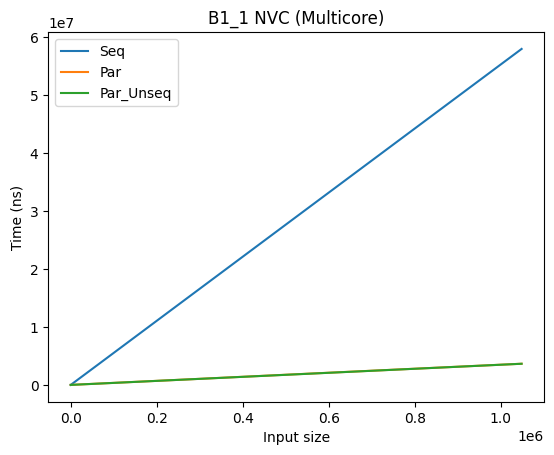

In [12]:
fig, ax = plt.subplots()

b1_1_nvc_mc_seq = extraction_pandas_frame_algo(
    root_dir + '/NVHPC_Multicore/DEFAULT/cleaned/b1_1_for_each_linear_seq_Default.csv')
b1_1_nvc_mc_seq.plot(x='n', y='real_time', ax=ax, label='Seq')

b1_1_nvc_mc_par = extraction_pandas_frame_algo(
    root_dir + '/NVHPC_Multicore/DEFAULT/cleaned/b1_1_for_each_linear_par_Default.csv')
b1_1_nvc_mc_par.plot(x='n', y='real_time', ax=ax, label='Par')

b1_1_nvc_mc_par_unseq = extraction_pandas_frame_algo(
    root_dir + '/NVHPC_Multicore/DEFAULT/cleaned/b1_1_for_each_linear_par_unseq_Default.csv')
b1_1_nvc_mc_par_unseq.plot(x='n', y='real_time', ax=ax, label='Par_Unseq')

ax.title.set_text("B1_1 NVC (Multicore)")

plt.ylabel('Time (ns)')
plt.xlabel('Input size')

plt.show()

## B1_1 NVC(Multicore) - Speedup (16) 
https://www.dcc.fc.up.pt/~ricroc/aulas/1516/cp/apontamentos/slides_metrics.pdf

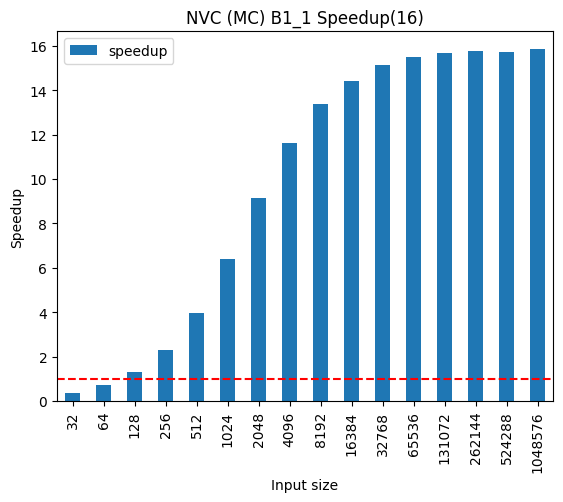

In [13]:
fig, ax = plt.subplots()

b1_1_nvc_mc_seq = extraction_pandas_frame_algo(
    root_dir + '/NVHPC_Multicore/DEFAULT/cleaned/b1_1_for_each_linear_seq_Default.csv')

b1_1_nvc_mc_par = extraction_pandas_frame_algo(
    root_dir + '/NVHPC_Multicore/DEFAULT/cleaned/b1_1_for_each_linear_par_Default.csv')

b1_1_nvc_mc_speed_up_16 = pd.concat(
    [b1_1_nvc_mc_seq['real_time'], b1_1_nvc_mc_par['real_time'], b1_1_nvc_mc_seq['n'], b1_1_nvc_mc_par['n']], axis=1,
    keys=['seq_real_time', 'par_real_time', 'seq_n', 'par_n'])
b1_1_nvc_mc_speed_up_16['speedup'] = b1_1_nvc_mc_speed_up_16['seq_real_time'] / b1_1_nvc_mc_speed_up_16['par_real_time']

b1_1_nvc_mc_speed_up_16.plot(kind='bar', x='seq_n', y='speedup', ax=ax)

# adding horizontal line where there is speedup
ax.axhline(y=1, color='r', linestyle='--')

plt.ylabel('Speedup')
plt.xlabel('Input size')

plt.title('NVC (MC) B1_1 Speedup(16)')

plt.show()

## B1_1 GCC - Efficiency (16) 
https://www.dcc.fc.up.pt/~ricroc/aulas/1516/cp/apontamentos/slides_metrics.pdf

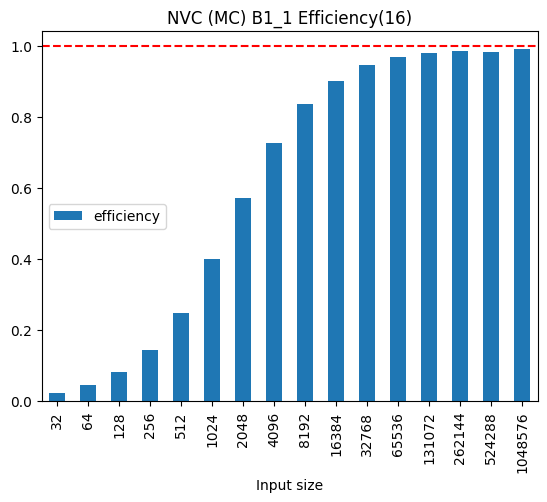

In [14]:
fig, ax = plt.subplots()

b1_1_nvc_mc_efficiency_16 = b1_1_nvc_mc_speed_up_16.copy()
b1_1_nvc_mc_efficiency_16['p'] = 16
b1_1_nvc_mc_efficiency_16['efficiency'] = b1_1_nvc_mc_efficiency_16['speedup'] / b1_1_nvc_mc_efficiency_16['p']

b1_1_nvc_mc_efficiency_16.plot(kind='bar', x='seq_n', y='efficiency', ax=ax)

# adding horizontal line where there is optimal efficiency
ax.axhline(y=1, color='r', linestyle='--')

plt.xlabel('Input size')

plt.title('NVC (MC) B1_1 Efficiency(16)')

plt.show()

## B1_1 - Par GCC VS NVHC (Multicore)

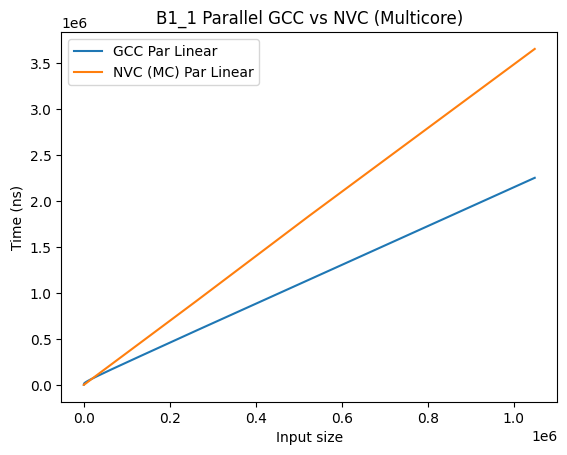

In [15]:
fig, ax = plt.subplots()

b1_1_gcc_par = extraction_pandas_frame_algo(root_dir + '/GCC_TBB/DEFAULT/cleaned/b1_1_for_each_linear_par_Default.csv')
b1_1_gcc_par.plot(x='n', y='real_time', ax=ax, label='GCC Par Linear')

b1_1_nvc_par = extraction_pandas_frame_algo(
    root_dir + '/NVHPC_Multicore/DEFAULT/cleaned/b1_1_for_each_linear_par_Default.csv')
b1_1_nvc_par.plot(x='n', y='real_time', ax=ax, label='NVC (MC) Par Linear')

plt.title("B1_1 Parallel GCC vs NVC (Multicore)")

plt.ylabel('Time (ns)')
plt.xlabel('Input size')

plt.show()

## B1_1 Speedup (16) - GCC vs NVHC(Multicore)

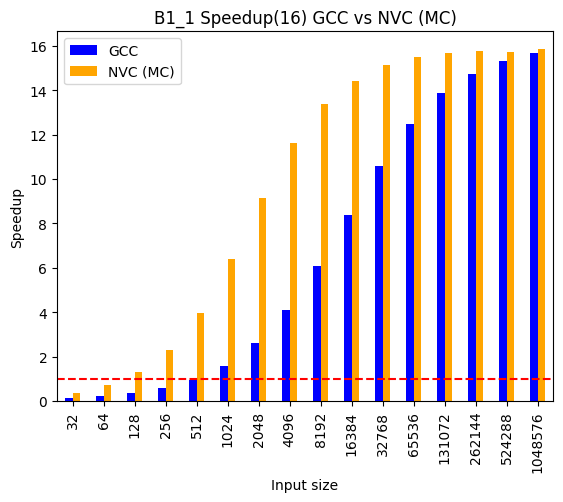

In [16]:
b1_1_nvc_mc_speed_up_16_tmp_copy = b1_1_nvc_mc_speed_up_16.copy()
b1_1_nvc_mc_speed_up_16_tmp_copy = b1_1_nvc_mc_speed_up_16_tmp_copy.drop(
    columns=['seq_real_time', 'par_real_time', 'seq_n'])
b1_1_nvc_mc_speed_up_16_tmp_copy = b1_1_nvc_mc_speed_up_16_tmp_copy.rename(
    columns={'par_n': 'n', 'speedup': 'NVC (MC)'})

b1_1_gcc_speed_up_16_tmp_copy = b1_1_gcc_speed_up_16.copy()
b1_1_gcc_speed_up_16_tmp_copy = b1_1_gcc_speed_up_16_tmp_copy.drop(columns=['seq_real_time', 'par_real_time', 'seq_n'])
b1_1_gcc_speed_up_16_tmp_copy = b1_1_gcc_speed_up_16_tmp_copy.rename(columns={'par_n': 'n', 'speedup': 'GCC'})

speed_up_16_merged_gcc_nvc_mc = pd.merge(b1_1_gcc_speed_up_16_tmp_copy, b1_1_nvc_mc_speed_up_16_tmp_copy, on='n')

ax = speed_up_16_merged_gcc_nvc_mc.plot.bar(x='n', color=['blue', 'orange'], align='center');

# adding horizontal line where there is speedup
ax.axhline(y=1, color='r', linestyle='--')

plt.ylabel('Speedup')
plt.xlabel('Input size')
plt.title('B1_1 Speedup(16) GCC vs NVC (MC)')

plt.show()

## B1_2 GCC - Outer Seq Speedup

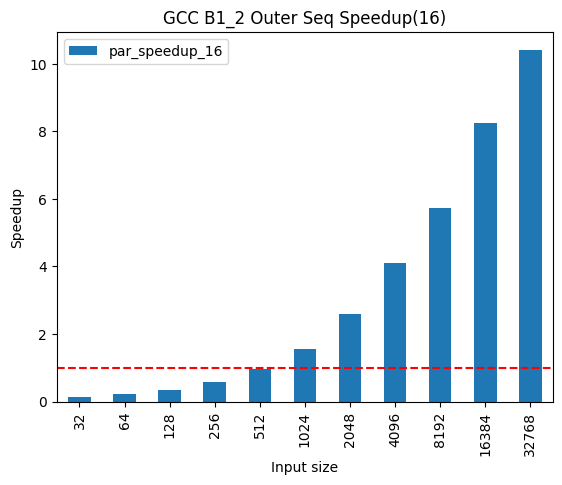

In [17]:
b1_2_gcc_seq_seq = extraction_pandas_frame_algo(
    root_dir + '/GCC_TBB/DEFAULT/cleaned/b1_2_for_each_quadratic_outer_std::execution::sequenced_policy_seq_Default.csv')
b1_2_gcc_seq_par = extraction_pandas_frame_algo(
    root_dir + '/GCC_TBB/DEFAULT/cleaned/b1_2_for_each_quadratic_outer_std::execution::sequenced_policy_par_Default.csv')
b1_2_gcc_seq_par_unseq = extraction_pandas_frame_algo(
    root_dir + '/GCC_TBB/DEFAULT/cleaned/b1_2_for_each_quadratic_outer_std::execution::sequenced_policy_par_unseq_Default.csv')

b1_2_gcc_seq_merged = pd.concat([
    b1_2_gcc_seq_seq['real_time'],
    b1_2_gcc_seq_par['real_time'],
    b1_2_gcc_seq_par_unseq['real_time'],
    b1_2_gcc_seq_seq['n'],
    b1_2_gcc_seq_par['n'],
    b1_2_gcc_seq_par_unseq['n']
], axis=1, keys=[
    'seq',
    'par',
    'par_unseq',
    'seq_n',
    'par_n',
    'par_unseq_n'
]
)

b1_2_gcc_seq_merged['par_speedup_16'] = b1_2_gcc_seq_merged['seq'] / b1_2_gcc_seq_merged['par']

ax = b1_2_gcc_seq_merged.plot(kind='bar', x='par_n', y=['par_speedup_16'])

# adding horizontal line where there is speedup
ax.axhline(y=1, color='r', linestyle='--')

plt.ylabel('Speedup')
plt.xlabel('Input size')

plt.title('GCC B1_2 Outer Seq Speedup(16)')

plt.show()

## B1_2 GCC - Speedup(16) Comparison  
We take the seq_seq (aka outer and inner is sequential) and calculate the speedups for all the other combos

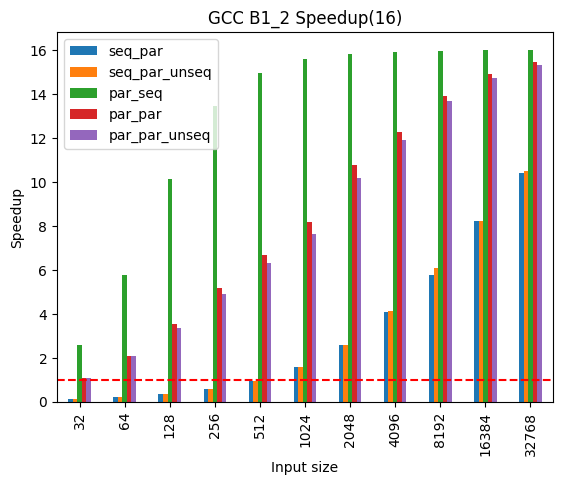

In [18]:
b1_2_gcc_par_seq = extraction_pandas_frame_algo(
    root_dir + '/GCC_TBB/DEFAULT/cleaned/b1_2_for_each_quadratic_outer_std::execution::parallel_policy_seq_Default.csv')
b1_2_gcc_par_par = extraction_pandas_frame_algo(
    root_dir + '/GCC_TBB/DEFAULT/cleaned/b1_2_for_each_quadratic_outer_std::execution::parallel_policy_par_Default.csv')
b1_2_gcc_par_par_unseq = extraction_pandas_frame_algo(
    root_dir + '/GCC_TBB/DEFAULT/cleaned/b1_2_for_each_quadratic_outer_std::execution::parallel_policy_par_unseq_Default.csv')

b1_2_gcc_par_merged = pd.concat([
    b1_2_gcc_seq_seq['real_time'],
    b1_2_gcc_seq_par['real_time'],
    b1_2_gcc_seq_par_unseq['real_time'],
    b1_2_gcc_par_seq['real_time'],
    b1_2_gcc_par_par['real_time'],
    b1_2_gcc_par_par_unseq['real_time'],
    b1_2_gcc_par_seq['n'],
    b1_2_gcc_par_par['n'],
    b1_2_gcc_par_par_unseq['n']
], axis=1, keys=[
    'seq_seq',
    'seq_par',
    'seq_par_unseq',
    'par_seq',
    'par_par',
    'par_par_unseq',
    'par_seq_n',
    'par_par_n',
    'par_par_unseq_n'
]
)


def calculate_speedup(name):
    b1_2_gcc_par_merged[name + '_speedup_16'] = b1_2_gcc_par_merged['seq_seq'] / b1_2_gcc_par_merged[name]


def calculate_efficiency(name):
    b1_2_gcc_par_merged[name + '_efficiency_16'] = b1_2_gcc_par_merged[name + '_speedup_16'] / 16


for name in ['seq_par', 'seq_par_unseq', 'par_seq', 'par_par', 'par_par_unseq']:
    calculate_speedup(name)
    calculate_efficiency(name)

ax = b1_2_gcc_par_merged.plot(kind='bar',
                              x='par_par_n',
                              y=['seq_par_speedup_16', 'seq_par_unseq_speedup_16', 'par_seq_speedup_16',
                                 'par_par_speedup_16', 'par_par_unseq_speedup_16'],
                              label=['seq_par', 'seq_par_unseq', 'par_seq', 'par_par', 'par_par_unseq']
                              )

# adding horizontal line where there is speedup
ax.axhline(y=1, color='r', linestyle='--')

plt.ylabel('Speedup')
plt.xlabel('Input size')

plt.title('GCC B1_2 Speedup(16)')

plt.show()


## B1_2 GCC - Efficiency comparison

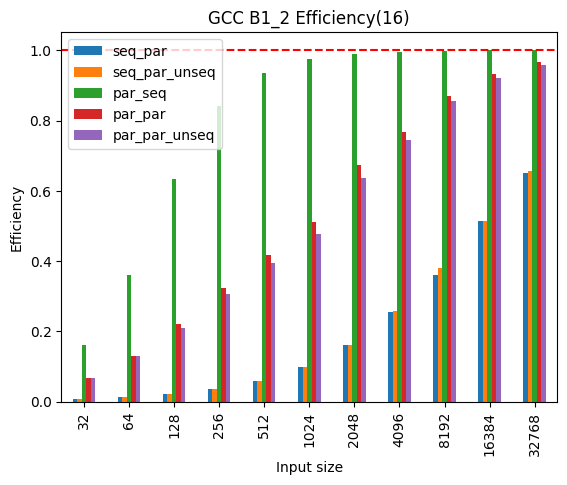

In [19]:
ax = b1_2_gcc_par_merged.plot(kind='bar',
                              x='par_par_n',
                              y=['seq_par_efficiency_16', 'seq_par_unseq_efficiency_16', 'par_seq_efficiency_16',
                                 'par_par_efficiency_16', 'par_par_unseq_efficiency_16'],
                              label=['seq_par', 'seq_par_unseq', 'par_seq', 'par_par', 'par_par_unseq']
                              )

# adding horizontal line where there is speedup
ax.axhline(y=1, color='r', linestyle='--')

plt.ylabel('Efficiency')
plt.xlabel('Input size')

plt.title('GCC B1_2 Efficiency(16)')

plt.show()

## B1_2 GCC - Runtime comparison

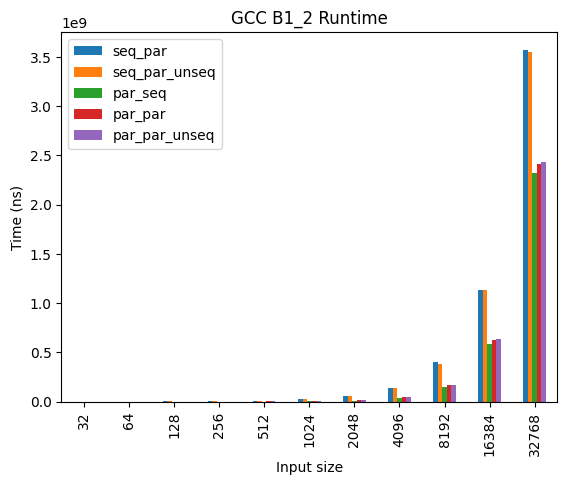

In [20]:
ax = b1_2_gcc_par_merged.plot(kind='bar',
                              x='par_par_n',
                              y=['seq_par', 'seq_par_unseq', 'par_seq', 'par_par', 'par_par_unseq'],
                              label=['seq_par', 'seq_par_unseq', 'par_seq', 'par_par', 'par_par_unseq']
                              )

plt.ylabel('Time (ns)')
plt.xlabel('Input size')

plt.title('GCC B1_2 Runtime')

plt.show()

## B1_2 NVC (MC) - Outer Seq Speedup

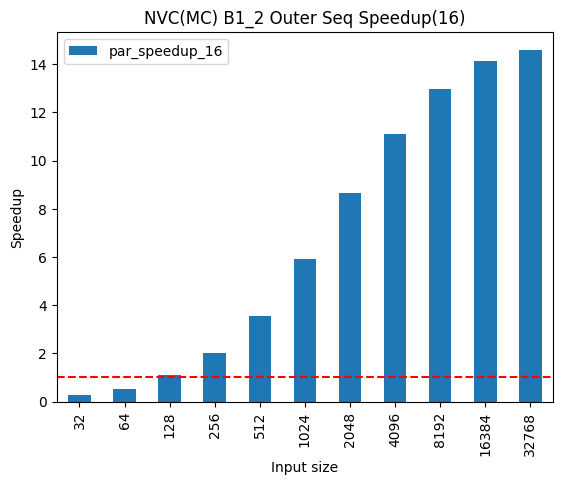

In [22]:
b1_2_nvc_mc_seq_seq = extraction_pandas_frame_algo(
    root_dir + '/NVHPC_Multicore/DEFAULT/cleaned/b1_2_for_each_quadratic_outer_std::execution::sequenced_policy_seq_Default.csv')
b1_2_nvc_mc_seq_par = extraction_pandas_frame_algo(
    root_dir + '/NVHPC_Multicore/DEFAULT/cleaned/b1_2_for_each_quadratic_outer_std::execution::sequenced_policy_par_Default.csv')
b1_2_nvc_mc_seq_par_unseq = extraction_pandas_frame_algo(
    root_dir + '/NVHPC_Multicore/DEFAULT/cleaned/b1_2_for_each_quadratic_outer_std::execution::sequenced_policy_par_unseq_Default.csv')

b1_2_nvc_mc_seq_merged = pd.concat([
    b1_2_nvc_mc_seq_seq['real_time'],
    b1_2_nvc_mc_seq_par['real_time'],
    b1_2_nvc_mc_seq_par_unseq['real_time'],
    b1_2_nvc_mc_seq_seq['n'],
    b1_2_nvc_mc_seq_par['n'],
    b1_2_nvc_mc_seq_par_unseq['n']
], axis=1, keys=[
    'seq',
    'par',
    'par_unseq',
    'seq_n',
    'par_n',
    'par_unseq_n'
]
)

b1_2_nvc_mc_seq_merged['par_speedup_16'] = b1_2_nvc_mc_seq_merged['seq'] / b1_2_nvc_mc_seq_merged['par']

ax = b1_2_nvc_mc_seq_merged.plot(kind='bar', x='par_n', y=['par_speedup_16'])

# adding horizontal line where there is speedup
ax.axhline(y=1, color='r', linestyle='--')

plt.ylabel('Speedup')
plt.xlabel('Input size')

plt.title('NVC(MC) B1_2 Outer Seq Speedup(16)')

plt.show()

## B1_2 NVC (MC) - Speedup(16) Comparison
We take the seq_seq (aka outer and inner is sequential) and calculate the speedups for all the other combos

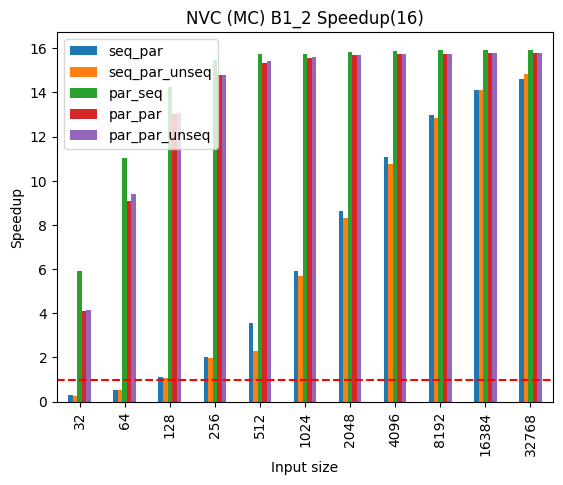

In [26]:
b1_2_nvc_mc_par_seq = extraction_pandas_frame_algo(
    root_dir + '/NVHPC_Multicore/DEFAULT/cleaned/b1_2_for_each_quadratic_outer_std::execution::parallel_policy_seq_Default.csv')
b1_2_nvc_mc_par_par = extraction_pandas_frame_algo(
    root_dir + '/NVHPC_Multicore/DEFAULT/cleaned/b1_2_for_each_quadratic_outer_std::execution::parallel_policy_par_Default.csv')
b1_2_nvc_mc_par_par_unseq = extraction_pandas_frame_algo(
    root_dir + '/NVHPC_Multicore/DEFAULT/cleaned/b1_2_for_each_quadratic_outer_std::execution::parallel_policy_par_unseq_Default.csv')

b1_2_nvc_mc_par_merged = pd.concat([
    b1_2_nvc_mc_seq_seq['real_time'],
    b1_2_nvc_mc_seq_par['real_time'],
    b1_2_nvc_mc_seq_par_unseq['real_time'],
    b1_2_nvc_mc_par_seq['real_time'],
    b1_2_nvc_mc_par_par['real_time'],
    b1_2_nvc_mc_par_par_unseq['real_time'],
    b1_2_nvc_mc_par_seq['n'],
    b1_2_nvc_mc_par_par['n'],
    b1_2_nvc_mc_par_par_unseq['n']
], axis=1, keys=[
    'seq_seq',
    'seq_par',
    'seq_par_unseq',
    'par_seq',
    'par_par',
    'par_par_unseq',
    'par_seq_n',
    'par_par_n',
    'par_par_unseq_n'
]
)


def calculate_speedup(name):
    b1_2_nvc_mc_par_merged[name + '_speedup_16'] = b1_2_nvc_mc_par_merged['seq_seq'] / b1_2_nvc_mc_par_merged[name]


def calculate_efficiency(name):
    b1_2_nvc_mc_par_merged[name + '_efficiency_16'] = b1_2_nvc_mc_par_merged[name + '_speedup_16'] / 16


for name in ['seq_par', 'seq_par_unseq', 'par_seq', 'par_par', 'par_par_unseq']:
    calculate_speedup(name)
    calculate_efficiency(name)

ax = b1_2_nvc_mc_par_merged.plot(kind='bar',
                                 x='par_par_n',
                                 y=['seq_par_speedup_16', 'seq_par_unseq_speedup_16', 'par_seq_speedup_16',
                                    'par_par_speedup_16', 'par_par_unseq_speedup_16'],
                                 label=['seq_par', 'seq_par_unseq', 'par_seq', 'par_par', 'par_par_unseq']
                                 )

# adding horizontal line where there is speedup
ax.axhline(y=1, color='r', linestyle='--')

plt.ylabel('Speedup')
plt.xlabel('Input size')

plt.title('NVC (MC) B1_2 Speedup(16)')

plt.show()


## B2_2 NVC (MC) - Efficiency Comparison

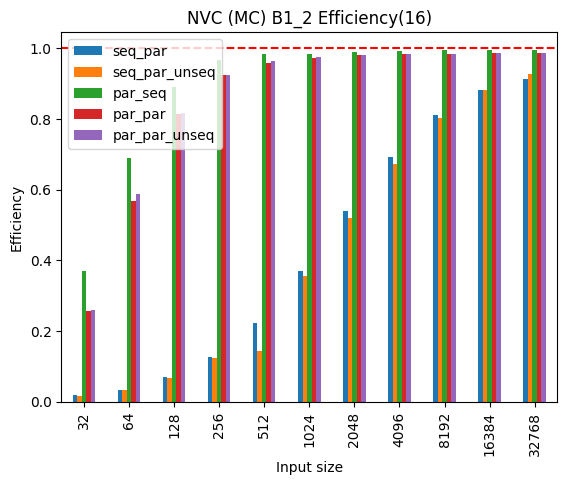

In [27]:
ax = b1_2_nvc_mc_par_merged.plot(kind='bar',
                                 x='par_par_n',
                                 y=['seq_par_efficiency_16', 'seq_par_unseq_efficiency_16', 'par_seq_efficiency_16',
                                    'par_par_efficiency_16', 'par_par_unseq_efficiency_16'],
                                 label=['seq_par', 'seq_par_unseq', 'par_seq', 'par_par', 'par_par_unseq']
                                 )

# adding horizontal line where there is speedup
ax.axhline(y=1, color='r', linestyle='--')

plt.ylabel('Efficiency')
plt.xlabel('Input size')

plt.title('NVC (MC) B1_2 Efficiency(16)')

plt.show()

## B2_2 NVC (MC) - Runtime comparison

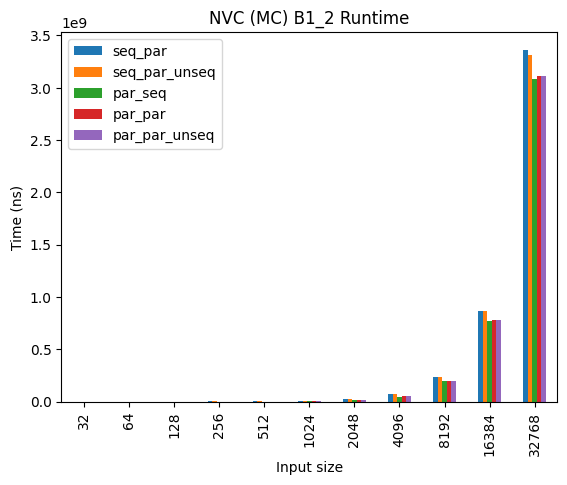

In [29]:
ax = b1_2_nvc_mc_par_merged.plot(kind='bar',
                                 x='par_par_n',
                                 y=['seq_par', 'seq_par_unseq', 'par_seq', 'par_par', 'par_par_unseq'],
                                 label=['seq_par', 'seq_par_unseq', 'par_seq', 'par_par', 'par_par_unseq']
                                 )

plt.ylabel('Time (ns)')
plt.xlabel('Input size')

plt.title('NVC (MC) B1_2 Runtime')

plt.show()

## B1_4 GCC - Speedup(16) comparison

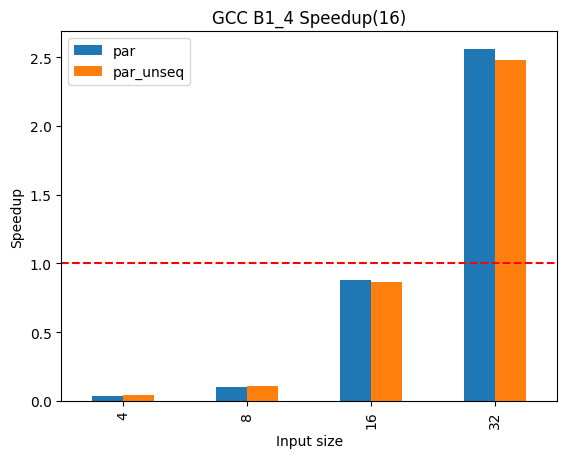

In [31]:
b1_4_gcc_seq = extraction_pandas_frame_algo(
    root_dir + '/GCC_TBB/DEFAULT/cleaned/b1_4_for_each_exponential_seq_Default.csv')
b1_4_gcc_par = extraction_pandas_frame_algo(
    root_dir + '/GCC_TBB/DEFAULT/cleaned/b1_4_for_each_exponential_par_Default.csv')
b1_4_gcc_par_unseq = extraction_pandas_frame_algo(
    root_dir + '/GCC_TBB/DEFAULT/cleaned/b1_4_for_each_exponential_par_unseq_Default.csv')

b1_4_gcc_merged = pd.concat([
    b1_4_gcc_seq['real_time'],
    b1_4_gcc_par['real_time'],
    b1_4_gcc_par_unseq['real_time'],
    b1_4_gcc_seq['n'],
    b1_4_gcc_par['n'],
    b1_4_gcc_par_unseq['n']
], axis=1, keys=[
    'seq',
    'par',
    'par_unseq',
    'seq_n',
    'par_n',
    'par_unseq_n'
]
)


def calculate_speedup(name):
    b1_4_gcc_merged[name + '_speedup_16'] = b1_4_gcc_merged['seq'] / b1_4_gcc_merged[name]


def calculate_efficiency(name):
    b1_4_gcc_merged[name + '_efficiency_16'] = b1_4_gcc_merged[name + '_speedup_16'] / 16


for name in ['par', 'par_unseq']:
    calculate_speedup(name)
    calculate_efficiency(name)

ax = b1_4_gcc_merged.plot(kind='bar',
                          x='par_n',
                          y=['par_speedup_16', 'par_unseq_speedup_16'],
                          label=['par', 'par_unseq']
                          )

# adding horizontal line where there is speedup
ax.axhline(y=1, color='r', linestyle='--')

plt.ylabel('Speedup')
plt.xlabel('Input size')

plt.title('GCC B1_4 Speedup(16)')

plt.show()


## B1_4 NVC (MC) - Speedup(16) comparison

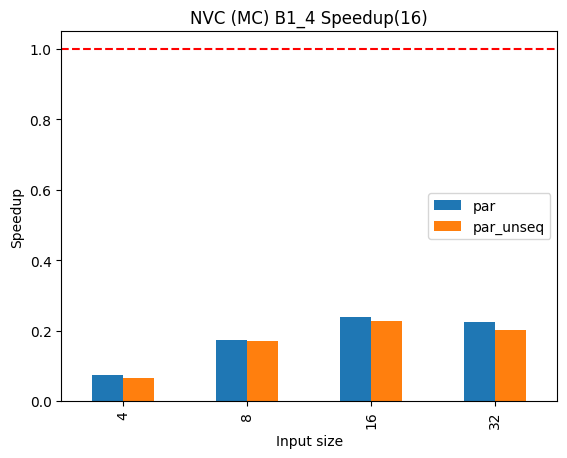

In [32]:
b1_4_nvc_mc_seq = extraction_pandas_frame_algo(
    root_dir + '/NVHPC_Multicore/DEFAULT/cleaned/b1_4_for_each_exponential_seq_Default.csv')
b1_4_nvc_mc_par = extraction_pandas_frame_algo(
    root_dir + '/NVHPC_Multicore/DEFAULT/cleaned/b1_4_for_each_exponential_par_Default.csv')
b1_4_nvc_mc_par_unseq = extraction_pandas_frame_algo(
    root_dir + '/NVHPC_Multicore/DEFAULT/cleaned/b1_4_for_each_exponential_par_unseq_Default.csv')

b1_4_nvc_mc_merged = pd.concat([
    b1_4_nvc_mc_seq['real_time'],
    b1_4_nvc_mc_par['real_time'],
    b1_4_nvc_mc_par_unseq['real_time'],
    b1_4_nvc_mc_seq['n'],
    b1_4_nvc_mc_par['n'],
    b1_4_nvc_mc_par_unseq['n']
], axis=1, keys=[
    'seq',
    'par',
    'par_unseq',
    'seq_n',
    'par_n',
    'par_unseq_n'
]
)


def calculate_speedup(name):
    b1_4_nvc_mc_merged[name + '_speedup_16'] = b1_4_nvc_mc_merged['seq'] / b1_4_nvc_mc_merged[name]


def calculate_efficiency(name):
    b1_4_nvc_mc_merged[name + '_efficiency_16'] = b1_4_nvc_mc_merged[name + '_speedup_16'] / 16


for name in ['par', 'par_unseq']:
    calculate_speedup(name)
    calculate_efficiency(name)

ax = b1_4_nvc_mc_merged.plot(kind='bar',
                             x='par_n',
                             y=['par_speedup_16', 'par_unseq_speedup_16'],
                             label=['par', 'par_unseq']
                             )

# adding horizontal line where there is speedup
ax.axhline(y=1, color='r', linestyle='--')

plt.ylabel('Speedup')
plt.xlabel('Input size')

plt.title('NVC (MC) B1_4 Speedup(16)')

plt.show()

## B2_1 GCC - Runtime comparision

Name: char_par Type_name: char Speedup: char_par_speedup_16 Seq_name: char_seq
Name: char_par_unseq Type_name: char Speedup: char_par_unseq_speedup_16 Seq_name: char_seq
Name: double_par Type_name: double Speedup: double_par_speedup_16 Seq_name: double_seq
Name: double_par_unseq Type_name: double Speedup: double_par_unseq_speedup_16 Seq_name: double_seq
Name: float_par Type_name: float Speedup: float_par_speedup_16 Seq_name: float_seq
Name: float_par_unseq Type_name: float Speedup: float_par_unseq_speedup_16 Seq_name: float_seq
Name: int_par Type_name: int Speedup: int_par_speedup_16 Seq_name: int_seq
Name: int_par_unseq Type_name: int Speedup: int_par_unseq_speedup_16 Seq_name: int_seq
Name: long_par Type_name: long Speedup: long_par_speedup_16 Seq_name: long_seq
Name: long_par_unseq Type_name: long Speedup: long_par_unseq_speedup_16 Seq_name: long_seq
Name: unsigned_long_par Type_name: unsigned_long Speedup: unsigned_long_par_speedup_16 Seq_name: unsigned_long_seq
Name: unsigned_long

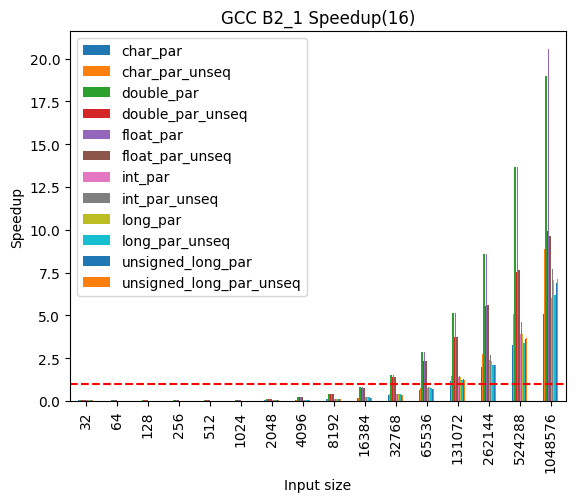

In [45]:
#char
b2_1_gcc_char_seq = extraction_pandas_frame_algo(
    root_dir + '/GCC_TBB/DEFAULT/cleaned/b2_1_basic_reduce_char_seq_Default.csv')
b2_1_gcc_char_par = extraction_pandas_frame_algo(
    root_dir + '/GCC_TBB/DEFAULT/cleaned/b2_1_basic_reduce_char_par_Default.csv')
b2_1_gcc_char_par_unseq = extraction_pandas_frame_algo(
    root_dir + '/GCC_TBB/DEFAULT/cleaned/b2_1_basic_reduce_char_par_unseq_Default.csv')

#double
b2_1_gcc_double_seq = extraction_pandas_frame_algo(
    root_dir + '/GCC_TBB/DEFAULT/cleaned/b2_1_basic_reduce_double_seq_Default.csv')
b2_1_gcc_double_par = extraction_pandas_frame_algo(
    root_dir + '/GCC_TBB/DEFAULT/cleaned/b2_1_basic_reduce_double_par_Default.csv')
b2_1_gcc_double_par_unseq = extraction_pandas_frame_algo(
    root_dir + '/GCC_TBB/DEFAULT/cleaned/b2_1_basic_reduce_double_par_unseq_Default.csv')

# float
b2_1_gcc_float_seq = extraction_pandas_frame_algo(
    root_dir + '/GCC_TBB/DEFAULT/cleaned/b2_1_basic_reduce_float_seq_Default.csv')
b2_1_gcc_float_par = extraction_pandas_frame_algo(
    root_dir + '/GCC_TBB/DEFAULT/cleaned/b2_1_basic_reduce_float_par_Default.csv')
b2_1_gcc_float_par_unseq = extraction_pandas_frame_algo(
    root_dir + '/GCC_TBB/DEFAULT/cleaned/b2_1_basic_reduce_float_par_unseq_Default.csv')

# int
b2_1_gcc_int_seq = extraction_pandas_frame_algo(
    root_dir + '/GCC_TBB/DEFAULT/cleaned/b2_1_basic_reduce_int_seq_Default.csv')
b2_1_gcc_int_par = extraction_pandas_frame_algo(
    root_dir + '/GCC_TBB/DEFAULT/cleaned/b2_1_basic_reduce_int_par_Default.csv')
b2_1_gcc_int_par_unseq = extraction_pandas_frame_algo(
    root_dir + '/GCC_TBB/DEFAULT/cleaned/b2_1_basic_reduce_int_par_unseq_Default.csv')

# long
b2_1_gcc_long_seq = extraction_pandas_frame_algo(
    root_dir + '/GCC_TBB/DEFAULT/cleaned/b2_1_basic_reduce_long_seq_Default.csv')
b2_1_gcc_long_par = extraction_pandas_frame_algo(
    root_dir + '/GCC_TBB/DEFAULT/cleaned/b2_1_basic_reduce_long_par_Default.csv')
b2_1_gcc_long_par_unseq = extraction_pandas_frame_algo(
    root_dir + '/GCC_TBB/DEFAULT/cleaned/b2_1_basic_reduce_long_par_unseq_Default.csv')

# unsigned_long
b2_1_gcc_unsigned_long_seq = extraction_pandas_frame_algo(
    root_dir + '/GCC_TBB/DEFAULT/cleaned/b2_1_basic_reduce_unsigned long_seq_Default.csv')
b2_1_gcc_unsigned_long_par = extraction_pandas_frame_algo(
    root_dir + '/GCC_TBB/DEFAULT/cleaned/b2_1_basic_reduce_unsigned long_par_Default.csv')
b2_1_gcc_unsigned_long_par_unseq = extraction_pandas_frame_algo(
    root_dir + '/GCC_TBB/DEFAULT/cleaned/b2_1_basic_reduce_unsigned long_par_unseq_Default.csv')

b2_1_gcc_merged = pd.concat([
    b2_1_gcc_char_seq['real_time'],
    b2_1_gcc_char_par['real_time'],
    b2_1_gcc_char_par_unseq['real_time'],
    b2_1_gcc_char_seq['n'],

    b2_1_gcc_double_seq['real_time'],
    b2_1_gcc_double_par['real_time'],
    b2_1_gcc_double_par_unseq['real_time'],
    b2_1_gcc_double_seq['n'],

    b2_1_gcc_float_seq['real_time'],
    b2_1_gcc_float_par['real_time'],
    b2_1_gcc_float_par_unseq['real_time'],
    b2_1_gcc_float_seq['n'],

    b2_1_gcc_int_seq['real_time'],
    b2_1_gcc_int_par['real_time'],
    b2_1_gcc_int_par_unseq['real_time'],
    b2_1_gcc_int_seq['n'],

    b2_1_gcc_long_seq['real_time'],
    b2_1_gcc_long_par['real_time'],
    b2_1_gcc_long_par_unseq['real_time'],
    b2_1_gcc_long_seq['n'],

    b2_1_gcc_unsigned_long_seq['real_time'],
    b2_1_gcc_unsigned_long_par['real_time'],
    b2_1_gcc_unsigned_long_par_unseq['real_time'],
    b2_1_gcc_unsigned_long_seq['n'],

], axis=1, keys=[
    'char_seq',
    'char_par',
    'char_par_unseq',
    'char_seq_n',

    'double_seq',
    'double_par',
    'double_par_unseq',
    'double_seq_n',

    'float_seq',
    'float_par',
    'float_par_unseq',
    'float_seq_n',

    'int_seq',
    'int_par',
    'int_par_unseq',
    'int_seq_n',

    'long_seq',
    'long_par',
    'long_par_unseq',
    'long_seq_n',

    'unsigned_long_seq',
    'unsigned_long_par',
    'unsigned_long_par_unseq',
    'unsigned_long_seq_n',
]
)


def calculate_speedup(name, type_name):
    print("Name:",name,"Type_name:",type_name,"Speedup:",name + '_speedup_16','Seq_name:',type_name + '_seq')
    b2_1_gcc_merged[name + '_speedup_16'] = b2_1_gcc_merged[type_name + '_seq'] / b2_1_gcc_merged[name]


def calculate_efficiency(name, type_name):
    b2_1_gcc_merged[name + '_efficiency_16'] = b2_1_gcc_merged[name + '_speedup_16'] / 16


for name, type_name in [
    ('char_par', 'char'),
    ('char_par_unseq', 'char'),
    ('double_par', 'double'),
    ('double_par_unseq', 'double'),
    ('float_par', 'float'),
    ('float_par_unseq', 'float'),
    ('int_par', 'int'),
    ('int_par_unseq', 'int'),
    ('long_par', 'long'),
    ('long_par_unseq', 'long'),
    ('unsigned_long_par', 'unsigned_long'),
    ('unsigned_long_par_unseq', 'unsigned_long'),
]:
    calculate_speedup(name, type_name)
    calculate_efficiency(name, type_name)

ax = b2_1_gcc_merged.plot(kind='bar',
                          x='char_seq_n',
                          y=[
                              'char_par_speedup_16', 'char_par_unseq_speedup_16',
                              'double_par_speedup_16', 'double_par_unseq_speedup_16',
                              'float_par_speedup_16', 'float_par_unseq_speedup_16',
                              'int_par_speedup_16', 'int_par_unseq_speedup_16',
                              'long_par_speedup_16', 'long_par_unseq_speedup_16',
                              'unsigned_long_par_speedup_16', 'unsigned_long_par_unseq_speedup_16',
                          ],
                          label=[
                              'char_par', 'char_par_unseq',
                              'double_par', 'double_par_unseq',
                              'float_par', 'float_par_unseq',
                              'int_par', 'int_par_unseq',
                              'long_par', 'long_par_unseq',
                              'unsigned_long_par', 'unsigned_long_par_unseq',
                          ]
                          )

# adding horizontal line where there is speedup
ax.axhline(y=1, color='r', linestyle='--')

plt.ylabel('Speedup')
plt.xlabel('Input size')

plt.title('GCC B2_1 Speedup(16)')

plt.show()

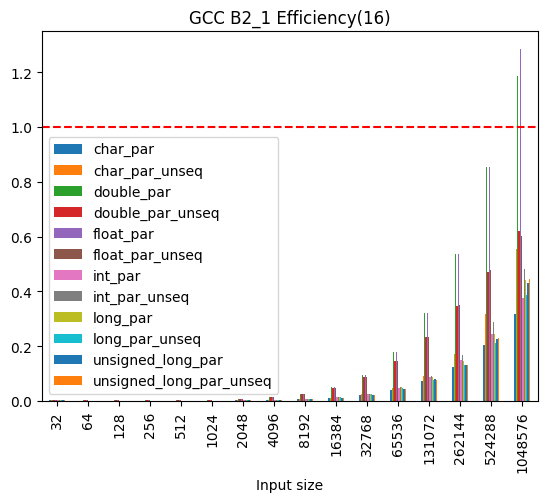

In [44]:
ax = b2_1_gcc_merged.plot(kind='bar',
                          x='char_seq_n',
                          y=[
                              'char_par_efficiency_16', 'char_par_unseq_efficiency_16',
                              'double_par_efficiency_16', 'double_par_unseq_efficiency_16',
                              'float_par_efficiency_16', 'float_par_unseq_efficiency_16',
                              'int_par_efficiency_16', 'int_par_unseq_efficiency_16',
                              'long_par_efficiency_16', 'long_par_unseq_efficiency_16',
                              'unsigned_long_par_efficiency_16', 'unsigned_long_par_unseq_efficiency_16',
                          ],
                          label=[
                              'char_par', 'char_par_unseq',
                              'double_par', 'double_par_unseq',
                              'float_par', 'float_par_unseq',
                              'int_par', 'int_par_unseq',
                              'long_par', 'long_par_unseq',
                              'unsigned_long_par', 'unsigned_long_par_unseq',
                          ]
                          )

# adding horizontal line where there is efficiency
ax.axhline(y=1, color='r', linestyle='--')

plt.xlabel('Input size')

plt.title('GCC B2_1 Efficiency(16)')

plt.show()

Looks like we have `superlinear speedup`
[https://stackoverflow.com/questions/4332967/where-does-super-linear-speedup-come-from/4454251#4454251](https://stackoverflow.com/questions/4332967/where-does-super-linear-speedup-come-from/4454251#4454251)

## B2_1 NVC (MC) - Speedup(16) Comparison

Name: char_par Type_name: char Speedup: char_par_speedup_16 Seq_name: char_seq
Name: char_par_unseq Type_name: char Speedup: char_par_unseq_speedup_16 Seq_name: char_seq
Name: double_par Type_name: double Speedup: double_par_speedup_16 Seq_name: double_seq
Name: double_par_unseq Type_name: double Speedup: double_par_unseq_speedup_16 Seq_name: double_seq
Name: float_par Type_name: float Speedup: float_par_speedup_16 Seq_name: float_seq
Name: float_par_unseq Type_name: float Speedup: float_par_unseq_speedup_16 Seq_name: float_seq
Name: int_par Type_name: int Speedup: int_par_speedup_16 Seq_name: int_seq
Name: int_par_unseq Type_name: int Speedup: int_par_unseq_speedup_16 Seq_name: int_seq
Name: long_par Type_name: long Speedup: long_par_speedup_16 Seq_name: long_seq
Name: long_par_unseq Type_name: long Speedup: long_par_unseq_speedup_16 Seq_name: long_seq
Name: unsigned_long_par Type_name: unsigned_long Speedup: unsigned_long_par_speedup_16 Seq_name: unsigned_long_seq
Name: unsigned_long

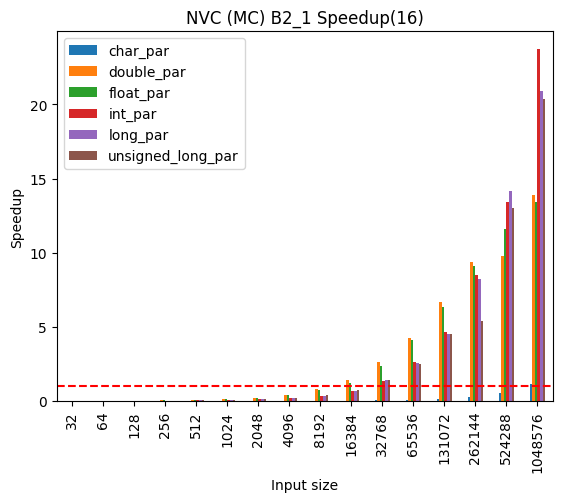

In [48]:
#char
b2_1_nvc_mc_char_seq = extraction_pandas_frame_algo(
    root_dir + '/NVHPC_Multicore/DEFAULT/cleaned/b2_1_basic_reduce_char_seq_Default.csv')
b2_1_nvc_mc_char_par = extraction_pandas_frame_algo(
    root_dir + '/NVHPC_Multicore/DEFAULT/cleaned/b2_1_basic_reduce_char_par_Default.csv')
b2_1_nvc_mc_char_par_unseq = extraction_pandas_frame_algo(
    root_dir + '/NVHPC_Multicore/DEFAULT/cleaned/b2_1_basic_reduce_char_par_unseq_Default.csv')

#double
b2_1_nvc_mc_double_seq = extraction_pandas_frame_algo(
    root_dir + '/NVHPC_Multicore/DEFAULT/cleaned/b2_1_basic_reduce_double_seq_Default.csv')
b2_1_nvc_mc_double_par = extraction_pandas_frame_algo(
    root_dir + '/NVHPC_Multicore/DEFAULT/cleaned/b2_1_basic_reduce_double_par_Default.csv')
b2_1_nvc_mc_double_par_unseq = extraction_pandas_frame_algo(
    root_dir + '/NVHPC_Multicore/DEFAULT/cleaned/b2_1_basic_reduce_double_par_unseq_Default.csv')

# float
b2_1_nvc_mc_float_seq = extraction_pandas_frame_algo(
    root_dir + '/NVHPC_Multicore/DEFAULT/cleaned/b2_1_basic_reduce_float_seq_Default.csv')
b2_1_nvc_mc_float_par = extraction_pandas_frame_algo(
    root_dir + '/NVHPC_Multicore/DEFAULT/cleaned/b2_1_basic_reduce_float_par_Default.csv')
b2_1_nvc_mc_float_par_unseq = extraction_pandas_frame_algo(
    root_dir + '/NVHPC_Multicore/DEFAULT/cleaned/b2_1_basic_reduce_float_par_unseq_Default.csv')

# int
b2_1_nvc_mc_int_seq = extraction_pandas_frame_algo(
    root_dir + '/NVHPC_Multicore/DEFAULT/cleaned/b2_1_basic_reduce_int_seq_Default.csv')
b2_1_nvc_mc_int_par = extraction_pandas_frame_algo(
    root_dir + '/NVHPC_Multicore/DEFAULT/cleaned/b2_1_basic_reduce_int_par_Default.csv')
b2_1_nvc_mc_int_par_unseq = extraction_pandas_frame_algo(
    root_dir + '/NVHPC_Multicore/DEFAULT/cleaned/b2_1_basic_reduce_int_par_unseq_Default.csv')

# long
b2_1_nvc_mc_long_seq = extraction_pandas_frame_algo(
    root_dir + '/NVHPC_Multicore/DEFAULT/cleaned/b2_1_basic_reduce_long_seq_Default.csv')
b2_1_nvc_mc_long_par = extraction_pandas_frame_algo(
    root_dir + '/NVHPC_Multicore/DEFAULT/cleaned/b2_1_basic_reduce_long_par_Default.csv')
b2_1_nvc_mc_long_par_unseq = extraction_pandas_frame_algo(
    root_dir + '/NVHPC_Multicore/DEFAULT/cleaned/b2_1_basic_reduce_long_par_unseq_Default.csv')

# unsigned_long
b2_1_nvc_mc_unsigned_long_seq = extraction_pandas_frame_algo(
    root_dir + '/NVHPC_Multicore/DEFAULT/cleaned/b2_1_basic_reduce_unsigned long_seq_Default.csv')
b2_1_nvc_mc_unsigned_long_par = extraction_pandas_frame_algo(
    root_dir + '/NVHPC_Multicore/DEFAULT/cleaned/b2_1_basic_reduce_unsigned long_par_Default.csv')
b2_1_nvc_mc_unsigned_long_par_unseq = extraction_pandas_frame_algo(
    root_dir + '/NVHPC_Multicore/DEFAULT/cleaned/b2_1_basic_reduce_unsigned long_par_unseq_Default.csv')

b2_1_nvc_mc_merged = pd.concat([
    b2_1_nvc_mc_char_seq['real_time'],
    b2_1_nvc_mc_char_par['real_time'],
    b2_1_nvc_mc_char_par_unseq['real_time'],
    b2_1_nvc_mc_char_seq['n'],

    b2_1_nvc_mc_double_seq['real_time'],
    b2_1_nvc_mc_double_par['real_time'],
    b2_1_nvc_mc_double_par_unseq['real_time'],
    b2_1_nvc_mc_double_seq['n'],

    b2_1_nvc_mc_float_seq['real_time'],
    b2_1_nvc_mc_float_par['real_time'],
    b2_1_nvc_mc_float_par_unseq['real_time'],
    b2_1_nvc_mc_float_seq['n'],

    b2_1_nvc_mc_int_seq['real_time'],
    b2_1_nvc_mc_int_par['real_time'],
    b2_1_nvc_mc_int_par_unseq['real_time'],
    b2_1_nvc_mc_int_seq['n'],

    b2_1_nvc_mc_long_seq['real_time'],
    b2_1_nvc_mc_long_par['real_time'],
    b2_1_nvc_mc_long_par_unseq['real_time'],
    b2_1_nvc_mc_long_seq['n'],

    b2_1_nvc_mc_unsigned_long_seq['real_time'],
    b2_1_nvc_mc_unsigned_long_par['real_time'],
    b2_1_nvc_mc_unsigned_long_par_unseq['real_time'],
    b2_1_nvc_mc_unsigned_long_seq['n'],

], axis=1, keys=[
    'char_seq',
    'char_par',
    'char_par_unseq',
    'char_seq_n',

    'double_seq',
    'double_par',
    'double_par_unseq',
    'double_seq_n',

    'float_seq',
    'float_par',
    'float_par_unseq',
    'float_seq_n',

    'int_seq',
    'int_par',
    'int_par_unseq',
    'int_seq_n',

    'long_seq',
    'long_par',
    'long_par_unseq',
    'long_seq_n',

    'unsigned_long_seq',
    'unsigned_long_par',
    'unsigned_long_par_unseq',
    'unsigned_long_seq_n',
]
)


def calculate_speedup(name, type_name):
    print("Name:",name,"Type_name:",type_name,"Speedup:",name + '_speedup_16','Seq_name:',type_name + '_seq')
    b2_1_nvc_mc_merged[name + '_speedup_16'] = b2_1_nvc_mc_merged[type_name + '_seq'] / b2_1_nvc_mc_merged[name]


def calculate_efficiency(name, type_name):
    b2_1_nvc_mc_merged[name + '_efficiency_16'] = b2_1_nvc_mc_merged[name + '_speedup_16'] / 16


for name, type_name in [
    ('char_par', 'char'),
    ('char_par_unseq', 'char'),
    ('double_par', 'double'),
    ('double_par_unseq', 'double'),
    ('float_par', 'float'),
    ('float_par_unseq', 'float'),
    ('int_par', 'int'),
    ('int_par_unseq', 'int'),
    ('long_par', 'long'),
    ('long_par_unseq', 'long'),
    ('unsigned_long_par', 'unsigned_long'),
    ('unsigned_long_par_unseq', 'unsigned_long'),
]:
    calculate_speedup(name, type_name)
    calculate_efficiency(name, type_name)

ax = b2_1_nvc_mc_merged.plot(kind='bar',
                          x='char_seq_n',
                          y=[
                              'char_par_speedup_16',# 'char_par_unseq_speedup_16',
                              'double_par_speedup_16',# 'double_par_unseq_speedup_16',
                              'float_par_speedup_16',# 'float_par_unseq_speedup_16',
                              'int_par_speedup_16',# 'int_par_unseq_speedup_16',
                              'long_par_speedup_16',# 'long_par_unseq_speedup_16',
                              'unsigned_long_par_speedup_16',# 'unsigned_long_par_unseq_speedup_16',
                          ],
                          label=[
                              'char_par',# 'char_par_unseq',
                              'double_par',# 'double_par_unseq',
                              'float_par',# 'float_par_unseq',
                              'int_par',# 'int_par_unseq',
                              'long_par',# 'long_par_unseq',
                              'unsigned_long_par',# 'unsigned_long_par_unseq',
                          ]
                          )

# adding horizontal line where there is speedup
ax.axhline(y=1, color='r', linestyle='--')

plt.ylabel('Speedup')
plt.xlabel('Input size')

plt.title('NVC (MC) B2_1 Speedup(16)')

plt.show()

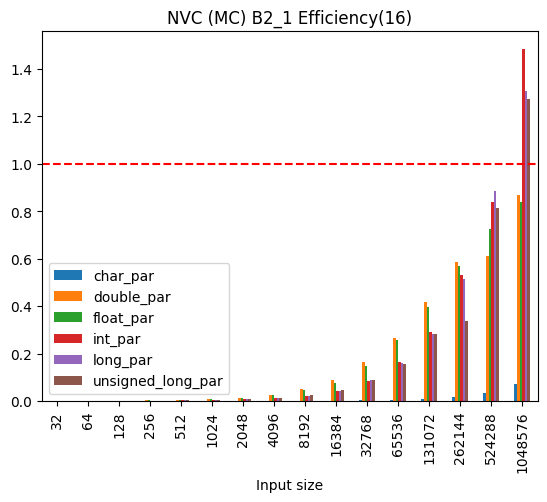

In [49]:
ax = b2_1_nvc_mc_merged.plot(kind='bar',
                          x='char_seq_n',
                          y=[
                              'char_par_efficiency_16',# 'char_par_unseq_efficiency_16',
                              'double_par_efficiency_16',# 'double_par_unseq_efficiency_16',
                              'float_par_efficiency_16',# 'float_par_unseq_efficiency_16',
                              'int_par_efficiency_16',# 'int_par_unseq_efficiency_16',
                              'long_par_efficiency_16',# 'long_par_unseq_efficiency_16',
                              'unsigned_long_par_efficiency_16',# 'unsigned_long_par_unseq_efficiency_16',
                          ],
                          label=[
                              'char_par',# 'char_par_unseq',
                              'double_par',# 'double_par_unseq',
                              'float_par',# 'float_par_unseq',
                              'int_par',# 'int_par_unseq',
                              'long_par',# 'long_par_unseq',
                              'unsigned_long_par',# 'unsigned_long_par_unseq',
                          ]
                          )

# adding horizontal line where there is efficiency
ax.axhline(y=1, color='r', linestyle='--')

plt.xlabel('Input size')

plt.title('NVC (MC) B2_1 Efficiency(16)')

plt.show()